## Universidad del Valle de Guatemala
##### Integrantes
* Juan Manuel Marroquin Alfaro 19845
* Carlos Alberto Raxtúm Ramos 19721
* Jose Abraham Gutierrez Corado 19111
* Walter Danilo Saldaña Salguero 19897
* Javier Alejandro Cotto Argueta 19324

## Investigación de PLN y Sistemas de Recomendación

Primeramente, la base de datos que escogimos esta basada en grabaciones de partidos de futbol de la liga alemana. Donde estos videos estan transcribidos
de forma que cada evento que ocurra en el partido se almacena, junto a su tiempo del evento(en segundo) y con su tipo de evento(pase, perdida/ganancia de posesión,
inicio y fin de la jugada, tiro libre, entre otras más). En base a esto, podemos detectar y reconocer cada tipo de evento que ocurra en un partido, en este caso
detectaremos lo que son los pases.

### Como parte de las tecnicas usadas para el Procesamiento de Lenguaje Natural, existen varias:

- Tokenizar
Esta tecnica consiste en separar cada palabra del texto  en entidades llamadas "tokens", de esta forma tendremos un mejor orden al trabajar con estas. Ademas de ello
a la hora de utilizar esta tecnica, se requiere identificar que utilizaremos como token y que no, por ejemplo contar las mayusculas y minusculas como un token o dos, 
los signos de puntuación seran tokens o no, y asi sucesivamente con cualquier letra o simbolo dentro de nuestras palabras.

- Tagging Part of Speech(PoS)
Esta tecnica se le conoce asi porque practicamente es trabajar las palabras como lo hacemos en la "vida real". Esto se debe a que clasificamos y reconocemos oraciones
mediante separarlas en articulo, verbo, sustantivo, adjetivo, entre otras más.

- Shallow parsing
Esta tecnica combina las dos anteriores, esto se debe a que con cada token obtenido y con cada clasificación hecha mediante PoS, se realiza un arbol que permite a la
computadora, navegar y moverse por el facilitando asi el entendimieno del lenguaje común para formar oraciones y con ellas parrafos.

- Pragmatic Analysis
Esta tecnica es más complicada para implemenetar, pues ademas de las anteriores, se incluye una clasificación de el como se mencionan o dicen las cosas. Esto quiere decir
que la tecnica se basa en interpretar el modo de las palabras, tales como sarcasmo, ironía, etc.

- Bag of Words
Esta tecnica combina el Tokenizar con el uso de matrices. Prácticamente llevara un conteo de las palabras que aparezcan en cierto parrafo mediante los tokens antes recabados.

- word2vec
Esta tecnica creemos que es una de las más eficientes, ya que recaba y memoriza cientos y cientos de palabras utilizadas en diferentes contextos. En base a estas, realiza
matrices de 300 dimensiones, las cuales guardan cada palabra cerca de otras palabras similares y de esta forma crear vocabularios que pueden ser utilizados por la 
computadora para interpretar cualquier parrafo.


# Problema planteado y datos

El problema es que hoy en día, la información y estadísticas de los partidos de fútbol son generados de forma manual por operadores humanos en tiempo real. Por la naturaleza de estos datos, son exclusivos para el uso de los profesionales que generan y por ende son dueños de los mismos datos o para competencias profesionales. Sin embargo, esta data sería muy valiosa para otras aplicaciones como por ejemplo para el fichaje y descrubrimiento de talento jóven, que quizá aún no tengan mucha visibilidad para las grandes organizaciones y por lo tanto no generen sufiecientes datos estadísticos para tener visibilidad y que no pasen por alto.

Para esto se nos pide poder detectar en videos de forma automática los pases en un partido inlcuyendose saques de banda y centros; y enfrentamientos entre jugadores de equipos contrarios en sus diferentes categorías (falta, robo de balón, entre otros), pasa así poder analizar competiciones inexploradas, como ligas juveniles o semiprofesionales o incluso sesiones de entrenamiento para así poder identificar talento oculto.

Los datos obtenidos de los clips de video nos serán de ayuda para entrenar un modelo que logre clasificar los eventos del partido en las categorías indicadas en función del tiempo del partido para así poder identificar los eventos de interes a los solicitados por los fichadores.


import libraries

In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy.stats import norm
import scipy.stats as stats
import seaborn as sns
from pandas_profiling import ProfileReport
%matplotlib inline

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
train = pd.read_csv('./videos/train.csv',low_memory=False)
# convert Nan to empty list
train[['event_attributes']] = train[['event_attributes']].fillna('')

In [4]:
train.head()

,video_id,time,event,event_attributes
0,1606b0e6_0,200.265822,start,
1,1606b0e6_0,201.150000,challenge,['ball_action_forced']
2,1606b0e6_0,202.765822,end,
3,1606b0e6_0,210.124111,start,
4,1606b0e6_0,210.870000,challenge,['opponent_dispossessed']


#### Pequena informacion de los datos antes de manipularlos

In [5]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
time,11218.0,1787.796418,860.84597,175.025822,1050.63525,1769.089449,2527.93275,3575.000727


In [6]:
train.describe(include=['O']).transpose()

,count,unique,top,freq
video_id,11218,12,1606b0e6_1,1249
event,11218,5,play,3586
event_attributes,11218,15,,6836


## Analisis Exploratorio

### Conteo de la clasificacion de tipo de eventos 

#### Grafica

En esta grafica lo que hacemos es identificar cuales son los posibles eventos dentro del dataframe y hacer un conteo de los mismos

<AxesSubplot:xlabel='count', ylabel='event'>

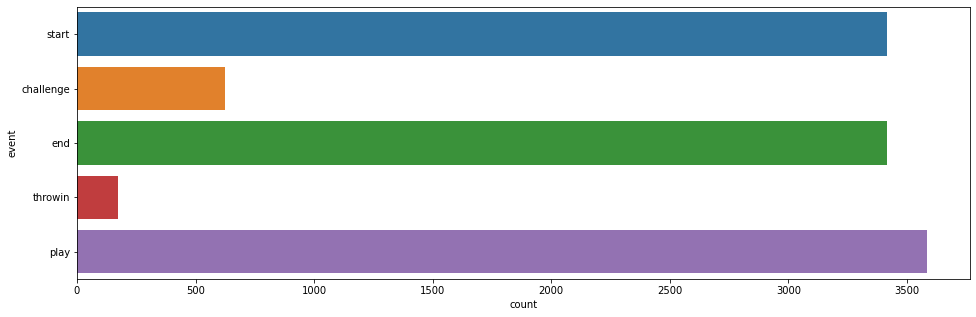

In [7]:
plt.figure(figsize=(16, 5))
sn.countplot(data=train, y="event")

#### Tabla de conteo

In [8]:
train['event'].value_counts().sort_index()

challenge     624
end          3418
play         3586
start        3418
throwin       172
Name: event, dtype: int64

#### Grafica de conteo de tipo de eventos por video

<AxesSubplot:xlabel='video_id', ylabel='count'>

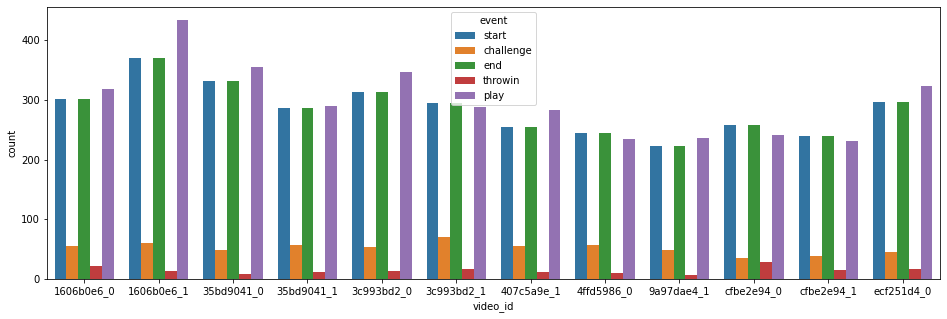

In [9]:
plt.figure(figsize=(16, 5))
sn.countplot(data=train, x="video_id", hue="event")

La primera grafica de barras no nos da mayor informacion mas que, que tipo de eventos ocurren a nivel general en los clips. Sin embargo, en la segunda grafica se puede que ocurre especificamente en cada clip. Esto nos ayudara a tener una base si nuestras predicciones son correctas respecto a estos mismos.

Lo que haremos es calcular cuántos eventos hay en un clip => Clip significa [Inicio ~ Fin] en la anotación train.csv
Los números de inicio y final son los mismos, así que haga que cada lista de valores => pares de (inicio y final) tengan el mismo índice de lista Y luego reste el mismo índice entre dos listas => (resultado-1) ¡será el número medio de eventos en un clip!

### Conteo de la clasificacion de tipo de atributos

#### Grafica
en esta grafica mostramos los atributos del evento, asi como pass, tiro etc

<AxesSubplot:xlabel='count', ylabel='event_attributes'>

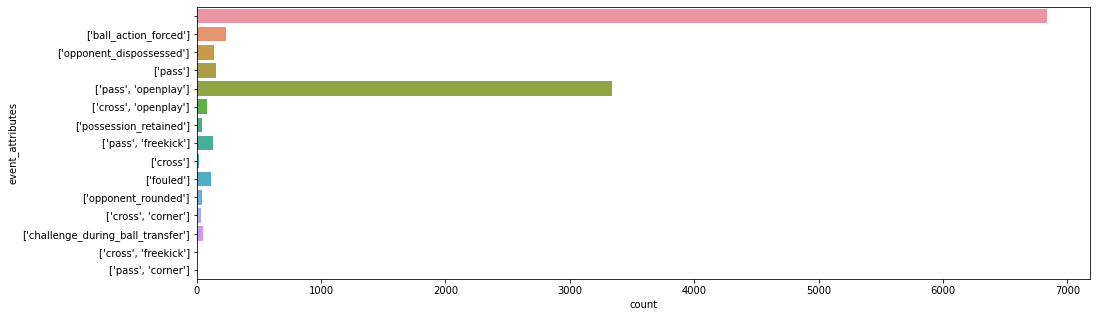

In [10]:
plt.figure(figsize=(16, 5))
sn.countplot(data=train, y="event_attributes")

#### Conteo

In [11]:
train['event_attributes'].value_counts().sort_index()

                                      6836
['ball_action_forced']                 239
['challenge_during_ball_transfer']      53
['cross', 'corner']                     33
['cross', 'freekick']                    5
['cross', 'openplay']                   80
['cross']                               18
['fouled']                             111
['opponent_dispossessed']              138
['opponent_rounded']                    39
['pass', 'corner']                       4
['pass', 'freekick']                   127
['pass', 'openplay']                  3337
['pass']                               154
['possession_retained']                 44
Name: event_attributes, dtype: int64

Esta grafica hacemos el recuento por id_de video cuantos acciones tuvieron un inicio y un fin

<AxesSubplot:xlabel='count', ylabel='video_id'>

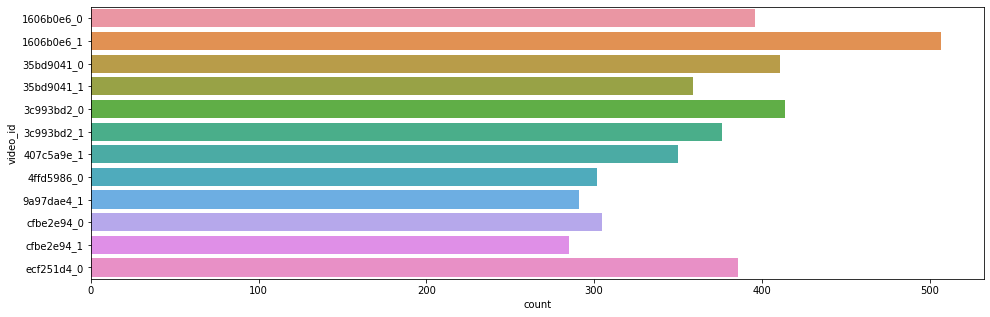

In [12]:
plt.figure(figsize=(16, 5))
sn.countplot(data=train[(train["event"] != "start") & (train["event"] != "end")], y="video_id")

In [13]:
train.groupby('event')['event_attributes'].value_counts().to_frame().sort_index()

event_attributes
event     event_attributes                                    
challenge ['ball_action_forced']                           239
          ['challenge_during_ball_transfer']                53
          ['fouled']                                       111
          ['opponent_dispossessed']                        138
          ['opponent_rounded']                              39
          ['possession_retained']                           44
end                                                       3418
play      ['cross', 'corner']                               33
          ['cross', 'freekick']                              5
          ['cross', 'openplay']                             80
          ['pass', 'corner']                                 4
          ['pass', 'freekick']                             127
          ['pass', 'openplay']                            3337
start                                                     3418
throwin   ['cross']                                         18
          ['pass']                                         154

In [14]:
start_idx = train[train['event']=='start'].index.values
end_idx = train[train['event']=='end'].index.values

for event_id, (start, end) in enumerate(zip(start_idx, end_idx)):
    train.loc[start:end, 'event_id'] = int(event_id)
    
train['event_id'] = train['event_id'].astype('int16')
del start_idx, end_idx

train

,video_id,time,event,event_attributes,event_id
0,1606b0e6_0,200.265822,start,,0
1,1606b0e6_0,201.150000,challenge,['ball_action_forced'],0
2,1606b0e6_0,202.765822,end,,0
3,1606b0e6_0,210.124111,start,,1
4,1606b0e6_0,210.870000,challenge,['opponent_dispossessed'],1
...,...,...,...,...,...
11213,ecf251d4_0,3056.587000,challenge,['opponent_dispossessed'],3416
11214,ecf251d4_0,3058.072895,end,,3416
11215,ecf251d4_0,3068.280519,start,,3417
11216,ecf251d4_0,3069.547000,throwin,['pass'],3417


### Limpieza de los datos: 
- Convertir el texto a mayúsculas o a minúsculas
- Quitar los caracteres especiales que aparecen como “#”,”@” o los apóstrofes y signos de puntuación
- Quitar las URL
- Revisar si hay emoticones y quitarlos
- Quitar los artículos, preposiciones y conjunciones (stopwords)
- Quitar números si considera que interferirán en la clasificación (quizá debería valorar si quitar o no el 911).

In [15]:
def cleanText(text):
  text = text.lower()
  text = deleteHashtag(text)
  text = deleteURL(text)
  text = deleteMention(text)
  text = re.sub(r'[^\w\s]', '', text)
  return text

def deleteHashtag(hashtag):
  if ('#' not in hashtag): 
    return hashtag

  hashtags = re.findall(r"#[^\s]*", hashtag, re.I)
  for h in hashtags:
    hashtag = hashtag.replace(h, '')
  return hashtag

def deleteURL(url):
  if ('http' not in url): 
    return url

  urls = re.findall(r"http[^\s]*", url, re.I)
  for u in urls:
    url = url.replace(u, '')
  return url

def deleteMention(mention): 
  if ('@' not in mention): 
    return mention

  mentions = re.findall(r"@[^\s]*", mention, re.I)
  for m in mentions:
    mention = mention.replace(m, '')
  return mention

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_quotes(text):
    quotes = re.compile(r'[^A-Za-z0-9\s]+')
    return re.sub(quotes, '', text)

#### Pandas Profiler

In [16]:
#profile = train.profile_report(title="EDA Detection Passes")
#profile.to_file(output_file="EDA.html")

In [17]:
df1 = pd.DataFrame([ x.replace('[','').replace(']','').replace("'",'').split(',') for x in train['event_attributes'].tolist() ])

2    2622
3     666
4     101
5      21
6       7
7       1
Name: event_number, dtype: int64


Text(0.5, 1.0, 'Distribution of Event Number in One Clip')

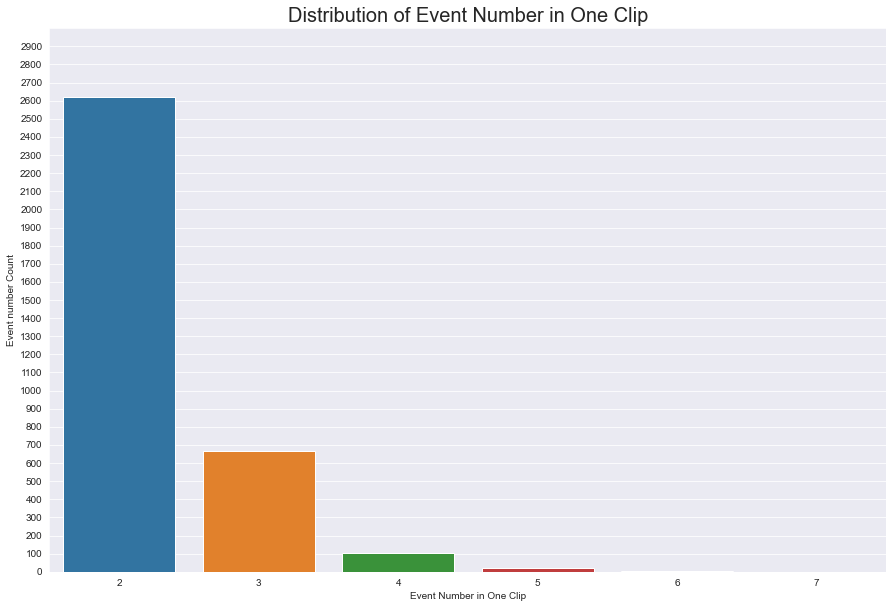

In [20]:

start_index = train.loc[train['event'] == 'start'].index
end_index = train.loc[train['event'] == 'end'].index

event_number = [end_index[i] - start_index[i] for i in range(len(start_index))]
event_number_df = pd.DataFrame(data=event_number, columns=['event_number'])

print(event_number_df['event_number'].value_counts())
sns.set_style(style='darkgrid')
plt.figure(figsize=(15,10))

graph = sns.countplot(data=event_number_df, x='event_number')
graph.set(ylim=(0,3000), yticks=np.arange(0,3000,100))
graph.set(xlabel="Event Number in One Clip", ylabel="Event number Count")
graph.set_title('Distribution of Event Number in One Clip', fontsize=20) 

Cada valor x - 1 => Número de evento en un clip
Ej. x.value 2 significa que en train.csv, hay 2622 clips que tienen "Solo un evento"
Ej) x.value 3 significa que en train.csv, hay 666 clips que tienen "Dos eventos"

Hay 6 tipos de Clip (Intervalo de evento)

Caso 1) Inicio - Evento 1 - Fin (2622)

Caso 2) Inicio - Evento 1 - Evento 2 - Fin (666)

Caso 3) Inicio - Evento 1 - Evento 2 - Evento 3 - Fin (101)

Caso 4) Inicio - Evento 1 - Evento 2 - Evento 3 - Evento 4 - Fin (21)

Caso 5) Inicio - Evento 1 - Evento 2 - Evento 3 - Evento 4 - Evento 5 - Fin (7)

Caso 6) Inicio - Evento 1 - Evento 2 - Evento 3 - Evento 4 - Evento 5 - Evento 6 - Fin (1)

In [21]:
# Paso 1.3 Calcular intervalo en tipo de clip
# Aplicar el mismo método en el paso anterior
start_time = list(train.loc[train['event'] == 'start'].time)
end_time = list(train.loc[train['event'] == 'end'].time)

event_duration = [np.around(end_time[i] - start_time[i],2) for i in range(len(start_time))]
event_duration_df = pd.DataFrame(data=event_duration, columns=['event_duration'])
print(event_duration_df.value_counts())

event_duration
2.50              2622
4.99                15
4.83                13
4.53                11
4.86                10
                  ... 
6.01                 1
6.00                 1
5.92                 1
5.79                 1
13.99                1
Length: 251, dtype: int64
